# Retraining of VGG model for use in case of breast cancer images. 

In [1]:
import scipy.io as sio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
data = sio.loadmat('histo_images.mat')

In [2]:
X = data['histo_images']
y = data['labels']

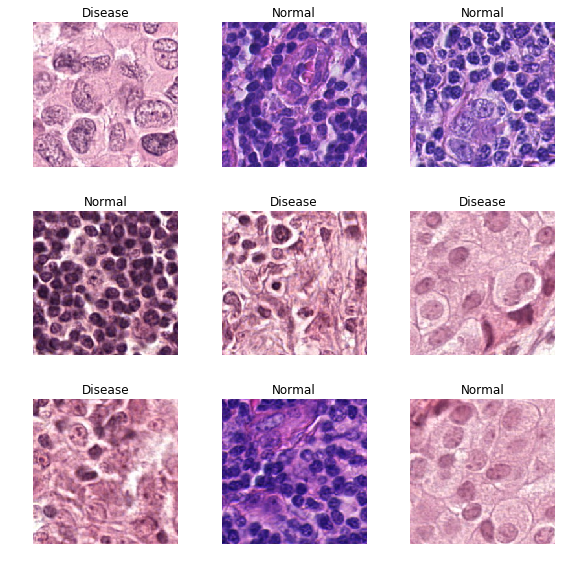

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))

for i, ax in enumerate(axes.flat, start=1):
    ii = np.random.randint(0, len(y))
    ax.imshow(X[:,:,:,ii])
    ax.axis('off')
    if y[ii][0] == 1:
        ax.set_title('Normal')
    else:
        ax.set_title('Disease')

fig.tight_layout()

plt.show()

In [98]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input


img_width, img_height = (X.shape[0], X.shape[1])

#Define model
model = applications.VGG19(weights = "imagenet", include_top=True, input_shape = (img_width, img_height, 3))
model = Model(inputs=model.input, outputs=model.get_layer('fc2').output)

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [100]:
#Forward pass

x = image.img_to_array(X[:,:,:,0])
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
print(features.flatten().shape)

(25088,)


In [101]:
n = X.shape[3]
features_all = np.zeros((n, features.flatten().shape[0]))
for i in range(n):
    if i % 50 == 0:
        print(i)
    x = image.img_to_array(X[:,:,:,i])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    features_all[i,:] = features.flatten()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [102]:
from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import normalize
normed = normalize(features_all)

knn = neighbors.KNeighborsClassifier(n_neighbors = 11, n_jobs=4)

knn.fit(normed, y.ravel()-1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=11, p=2,
           weights='uniform')

In [103]:
pred = knn.predict(features_all)
print(accuracy_score(y.ravel()-1, pred))

0.8548387096774194


In [93]:
## It is seen that we acheive a 88% accuracy on our data with the KNN approach with 11 neighbours

In [94]:

tot_acc = []

for cross in range(1,10):
    print(cross)
    v = np.array(list(range(1,y.shape[0])))
    np.random.shuffle(v)
    v_train = v[:880]
    v_test = v[880:]
    acc_inner = []
    for K in range(1,20):
        knn = neighbors.KNeighborsClassifier(n_neighbors = K, n_jobs=4)

        knn.fit(normed[v_train,:], y.ravel()[v_train]-1)

        pred = knn.predict(features_all[v_test,:])
        acc_inner.append(accuracy_score(y.ravel()[v_test]-1, pred))
        
    tot_acc.append(acc_inner)
        

1
2
3
4
5
6
7
8
9


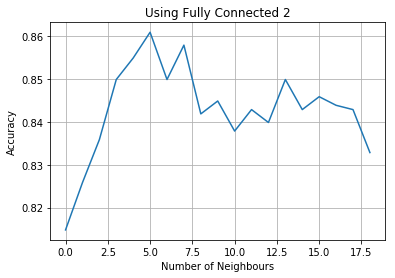

In [96]:
tot_acc_np = np.array(tot_acc)
plt.plot(np.mean(tot_acc_np, axis= 0))
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.title("Using Fully Connected 2")
plt.grid()
plt.show()

In [63]:
import pandas as pd

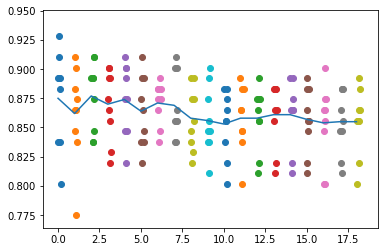

In [84]:
df = pd.DataFrame(tot_acc_np)
for i, h in enumerate(tot_acc_np.T):
    plt.scatter(np.ones(h.size) * i + np.random.rand(h.size)*0.2, h)

plt.plot(np.mean(tot_acc_np, axis= 0))
plt.show()